# Multi modal model

In [ ]:
%pip install --upgrade pip
%pip install tensorflow
%pip install yfinance
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install pytorch-lightning
%pip install transformers

In [383]:
import yfinance as yf
import numpy as np
import pandas as pd
import glob
import re
import nltk
import nest_asyncio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from calendar import monthrange
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle
from datetime import datetime, timedelta, date
import pytz
import torch
import torch.nn as nn
import torch.utils.data as td
import sklearn
import pytorch_lightning as pl
from typing import List, Optional
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from joblib import Parallel, delayed
import joblib
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
%matplotlib inline
nltk.download("stopwords")
import torch
from sklearn.preprocessing import MinMaxScaler
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import LSTM,Conv1D, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computing\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Fetch financial record from 1st January 2015 - 31st May 2021

In [3]:
start_date ='2015-01-01'
end_date = '2021-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [5]:
price = price.reset_index()

In [6]:
price_2= price.Close.to_frame()
price['PriceChange'] = price['Close'].pct_change() * 100 
price['Label'] = np.where(price['PriceChange'] > 0, 1, 0)

price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0.02)

# Calculate the percentage change in the Close price
price['Close_pct_change'] = price['Close'].pct_change()

# Create a binary column indicating if the Close price increased (1) or decreased (0)
price['Close_increase'] = (price['Close_pct_change'] > 0).astype(int)

# Fill any NaN values in the new columns with 0 (for the first row)
price['Close_pct_change'].fillna(0, inplace=True)
price['Close_increase'].fillna(0, inplace=True)

# Drop the 'Close_pct_change' column if you no longer need it
price.drop('Close_pct_change', axis=1, inplace=True)


In [7]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,change_label,Close_increase
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,0,NaN,NaN,False,0
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,0.249172,1,0.002492,0.002489,False,1
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,-10.776686,0,-0.107767,-0.114028,False,0
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,-6.007853,0,-0.060079,-0.061959,False,0
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,3.890684,1,0.038907,0.038169,True,1


In [ ]:
price.shape

(2536, 23)

### Compute moving average

In [8]:
# We will compute 7, 14, 21 simple moving average moving average 
# Due to the high volatility nature of crypto currency we chose a 1 day lag

lag = 1  # Number of lags
price['Close Lagged Price'] = price['Close'].shift(lag)
price['sma7'] = price['Close'].rolling(window=7).mean()
price['sma14'] = price['Close'].rolling(window=14).mean()
price['sma21'] = price['Close'].rolling(window=21).mean()


price['ema12'] = price['Close'].ewm(span=12, adjust=False).mean()
price['ema26'] = price['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
price['MACD line'] = price['ema12'] - price['ema26']

# Calculate Signal Line
price['Signal line'] = price['MACD line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
price['MACD histogram'] = price['MACD line'] - price['Signal line']

In [9]:
window = 14  # Number of periods for RSI calculation

# Calculate price changes
delta = price['Close'].diff()

# Calculate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

price['rsi'] = rsi


In [10]:
price.shape

(2556, 23)

In [275]:
price.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,...,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
2551,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.752840,1,0.007528,...,50429.859375,49613.073103,48354.407924,48720.261347,49445.238442,50481.798187,-1036.559746,-1828.605036,792.045291,52.409775
2552,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.332807,0,-0.003328,...,50809.515625,50150.236049,48633.189174,48723.013393,49629.112215,50493.547801,-864.435586,-1635.771146,771.335561,66.874820
2553,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-6.025943,0,-0.060259,...,50640.417969,49957.699219,48702.919364,48574.859561,49315.226562,50278.385406,-963.158844,-1501.248686,538.089842,53.368353
2554,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,-2.404228,0,-0.024042,...,47588.855469,49645.727679,48527.775670,48381.522135,48873.608773,49994.409519,-1120.800746,-1425.159098,304.358352,40.817228
2555,2021-12-30,46490.605469,47879.964844,46060.312500,47178.125000,47178.125000,26686491018,1.579112,1,0.015791,...,46444.710938,49130.525670,48492.968471,48357.998512,48612.765116,49785.795851,-1173.030735,-1374.733425,201.702690,48.104370


In [12]:
price = price.dropna()

In [13]:
price.isnull().value_counts()

Date   Open   High   Low    Close  Adj Close  Volume  PriceChange  Label  change  log_change  change_label  Close_increase  Close Lagged Price  sma7   sma14  sma21  ema12  ema26  MACD line  Signal line  MACD histogram  rsi  
False  False  False  False  False  False      False   False        False  False   False       False         False           False               False  False  False  False  False  False      False        False           False    2536
Name: count, dtype: int64

In [274]:
price.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,...,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
count,2536,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2.536000e+03,2536.000000,2536.000000,2536.000000,...,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000
mean,2018-07-11 12:00:00,11246.997897,11555.577008,10909.864446,11263.631256,11263.631256,1.517907e+10,0.288704,0.546136,0.002887,...,11245.111220,11207.006059,11139.092103,11073.016578,11158.695988,11019.491087,139.204901,141.337542,-2.132641,55.063053
min,2015-01-21 00:00:00,210.067993,221.807007,199.567001,210.494995,210.494995,1.060090e+07,-37.169539,0.000000,-0.371695,...,210.494995,211.516142,222.873070,226.947285,224.303720,230.699055,-5053.274080,-4438.999056,-1694.518206,4.699489
25%,2016-10-15 18:00:00,678.182999,689.981476,666.990509,679.170242,679.170242,1.024642e+08,-1.219800,0.000000,-0.012198,...,678.060760,672.128756,664.496703,664.104869,666.466516,655.304978,-38.024916,-37.702087,-25.022909,41.586534
50%,2018-07-11 12:00:00,6457.810059,6549.650146,6353.985107,6466.239990,6466.239990,5.401853e+09,0.208586,1.000000,0.002086,...,6463.209961,6453.512033,6482.959333,6494.722877,6491.819603,6593.480286,7.773846,7.453701,0.818015,55.149235
75%,2020-04-05 06:00:00,10387.225098,10659.444824,10161.807617,10398.342529,10398.342529,2.536664e+10,1.826447,1.000000,0.018264,...,10380.229248,10414.751500,10413.555455,10328.265916,10419.221618,10348.360750,217.695610,224.559582,35.227041,68.184758
max,2021-12-30 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,25.247169,1.000000,0.252472,...,67566.828125,65510.879464,63983.060826,63016.876488,64182.504548,62406.255181,5273.808690,4517.102703,1305.313389,99.765628
std,NaN,15903.297957,16342.360459,15402.312303,15913.178024,15913.178024,2.029669e+10,3.862109,0.497965,0.038621,...,15898.687419,15845.944146,15763.879159,15684.185419,15766.607822,15559.196275,946.838437,898.711236,261.129320,18.447736


In [ ]:
price.info()

In [16]:
price_corr = price.drop(['Date'], axis=1)

In [17]:
price_corr.corr()

,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,...,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
Open,1.000000,0.999518,0.999055,0.998794,0.998794,0.729450,-0.022699,-0.040707,-0.022699,-0.024511,...,0.999993,0.998682,0.995967,0.992947,0.997784,0.993385,0.290852,0.320717,-0.049177,-0.021174
High,0.999518,1.000000,0.999011,0.999479,0.999479,0.732952,-0.006628,-0.030312,-0.006628,-0.008974,...,0.999513,0.998525,0.995810,0.992770,0.997661,0.993209,0.291703,0.320899,-0.046719,-0.017601
Low,0.999055,0.999011,1.000000,0.999376,0.999376,0.721867,-0.003781,-0.028277,-0.003781,-0.005074,...,0.999061,0.997715,0.994738,0.991677,0.996794,0.992177,0.294234,0.321590,-0.039922,-0.015440
Close,0.998794,0.999479,0.999376,1.000000,1.000000,0.728381,0.008707,-0.019989,0.008707,0.006751,...,0.998803,0.997834,0.994859,0.991744,0.996911,0.992219,0.295498,0.322748,-0.039323,-0.012924
Adj Close,0.998794,0.999479,0.999376,1.000000,1.000000,0.728381,0.008707,-0.019989,0.008707,0.006751,...,0.998803,0.997834,0.994859,0.991744,0.996911,0.992219,0.295498,0.322748,-0.039323,-0.012924
Volume,0.729450,0.732952,0.721867,0.728381,0.728381,1.000000,-0.001276,-0.031640,-0.001276,-0.008479,...,0.729408,0.730464,0.726824,0.721659,0.727763,0.720404,0.280361,0.313231,-0.061454,0.016472
PriceChange,-0.022699,-0.006628,-0.003781,0.008707,0.008707,-0.001276,1.000000,0.655933,1.000000,0.997854,...,-0.022720,-0.018178,-0.021425,-0.022692,-0.018446,-0.022164,0.057056,0.022726,0.128668,0.272985
Label,-0.040707,-0.030312,-0.028277,-0.019989,-0.019989,-0.031640,0.655933,1.000000,0.655933,0.652156,...,-0.040790,-0.036580,-0.038564,-0.038974,-0.036772,-0.038564,0.021400,-0.000422,0.079051,0.230167
change,-0.022699,-0.006628,-0.003781,0.008707,0.008707,-0.001276,1.000000,0.655933,1.000000,0.997854,...,-0.022720,-0.018178,-0.021425,-0.022692,-0.018446,-0.022164,0.057056,0.022726,0.128668,0.272985
log_change,-0.024511,-0.008974,-0.005074,0.006751,0.006751,-0.008479,0.997854,0.652156,0.997854,1.000000,...,-0.024531,-0.020132,-0.023455,-0.024742,-0.020434,-0.024196,0.057340,0.022541,0.130335,0.274736


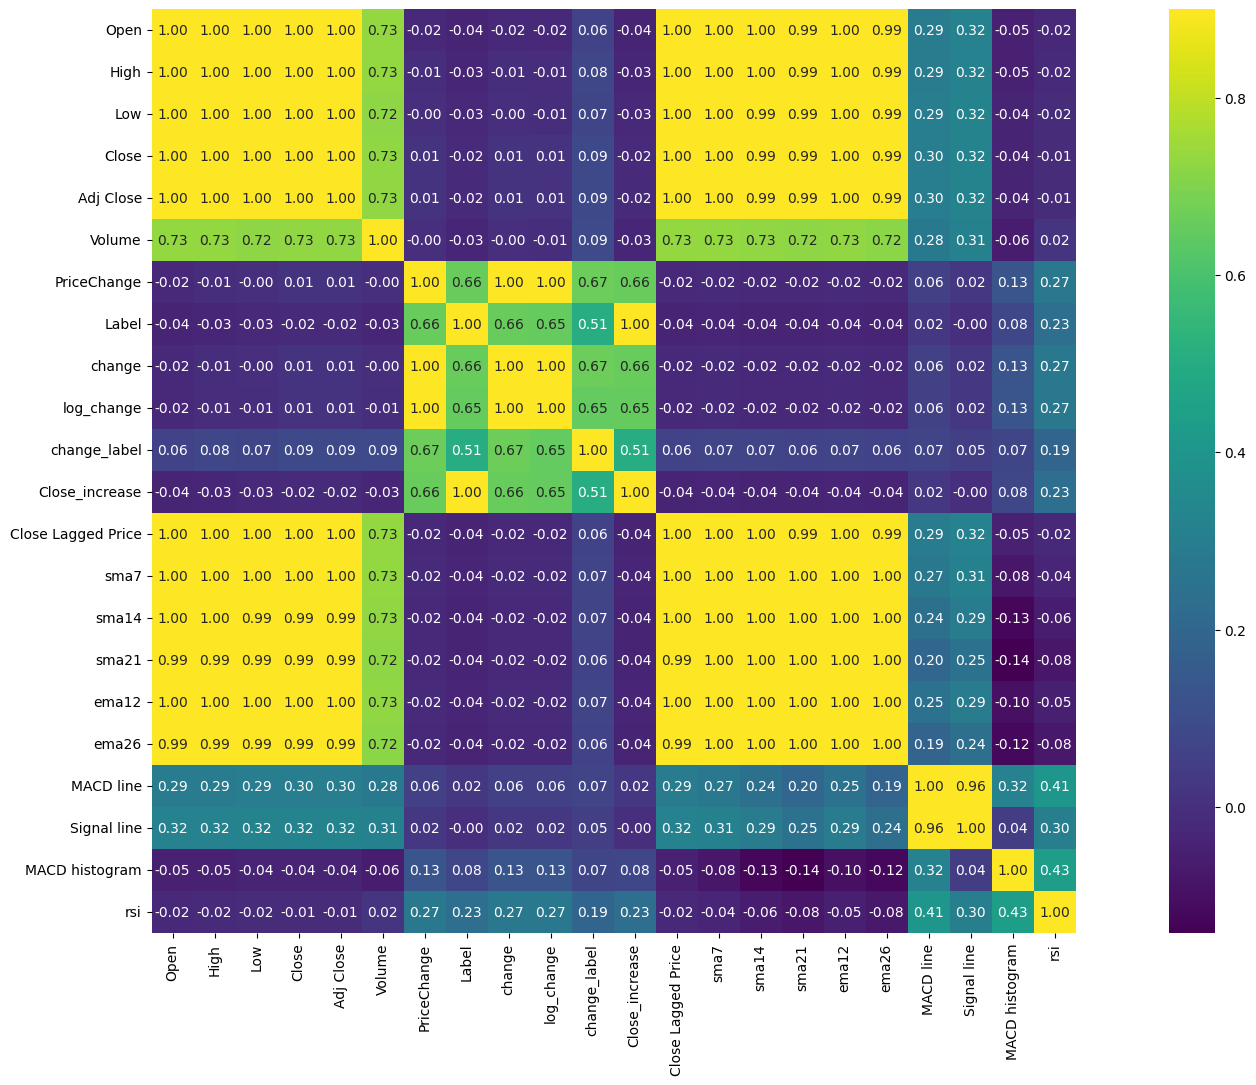

In [18]:
corrmat = price_corr.corr()

ax = plt.subplots(figsize = (24, 12))

sns.heatmap(corrmat, vmax = 0.9, square = True, annot = True, fmt = '0.2f', cmap = 'viridis');

c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Label', ylabel='count'>

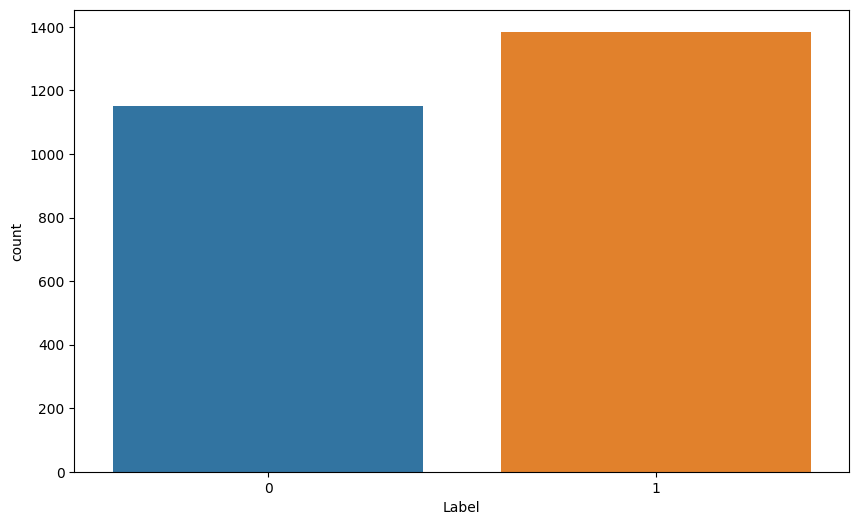

In [273]:
plt.figure(figsize = (10, 6))

sns.countplot(x='Label', data = price)

In [20]:
price['Label'].value_counts()

Label
1    1385
0    1151
Name: count, dtype: int64

In [ ]:
# price.skew()

<Figure size 1200x600 with 0 Axes>

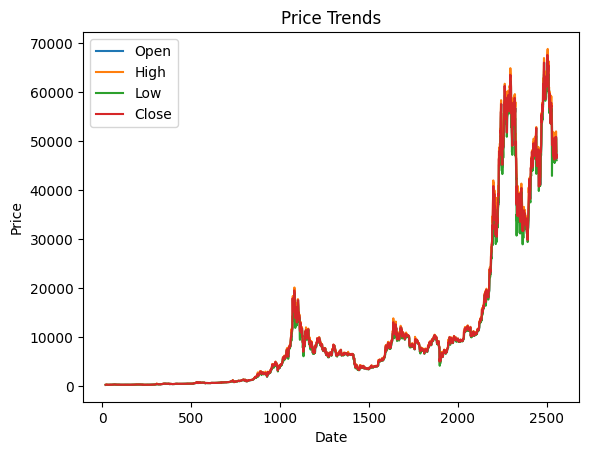

In [21]:
# Plotting Open, High, Low, Close
plt.figure(figsize=(12, 6))
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

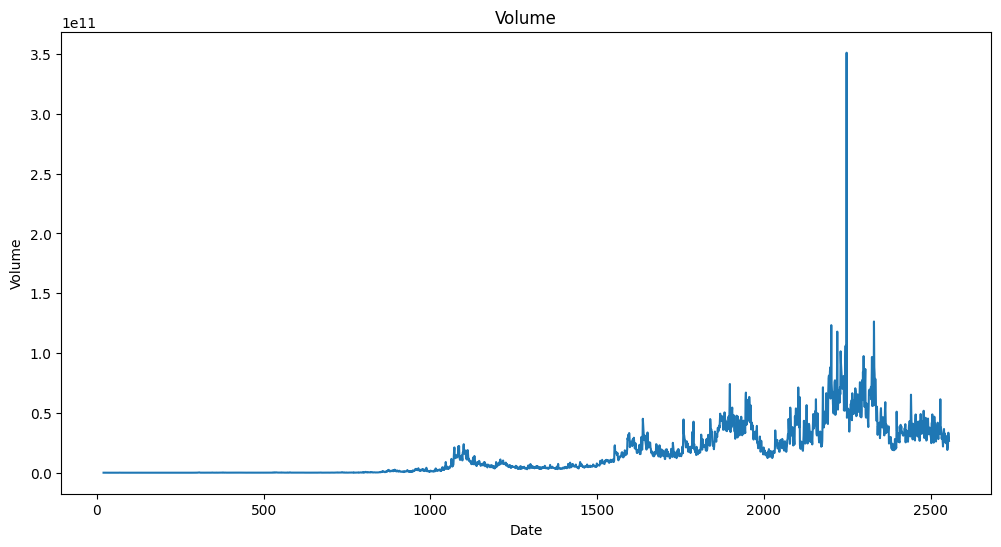

In [22]:
# Plotting Volume
plt.figure(figsize=(12, 6))
price['Volume'].plot()
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

<Figure size 1200x600 with 0 Axes>

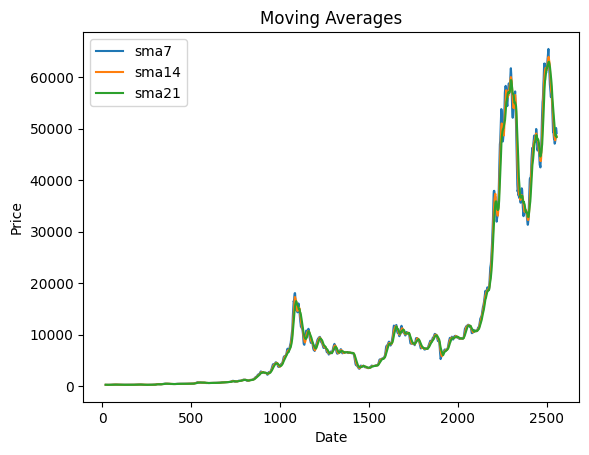

In [23]:
# Plotting Moving Averages
plt.figure(figsize=(12, 6))
price[['sma7', 'sma14', 'sma21']].plot()
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

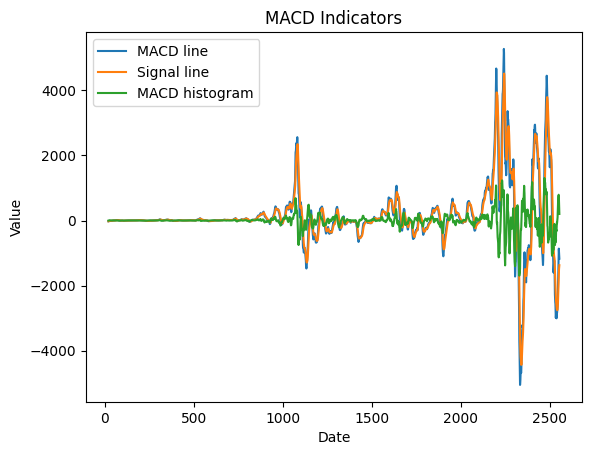

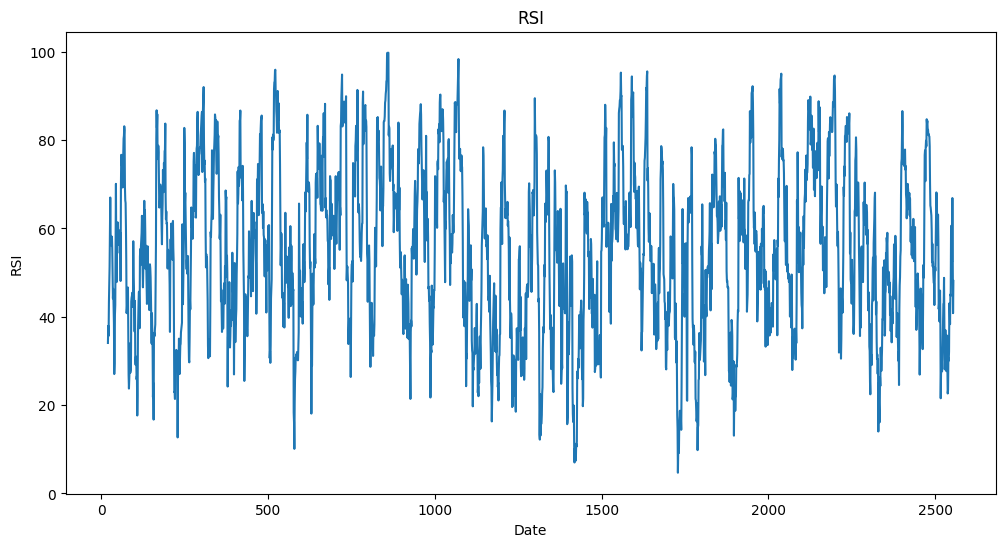

In [24]:
# Plotting MACD Line, Signal Line, MACD Histogram
plt.figure(figsize=(12, 6))
price[['MACD line', 'Signal line', 'MACD histogram']].plot()
plt.title('MACD Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 6))
price['rsi'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

In [ ]:
price.info()

### Process tweets

In [27]:
tweets_2015 = pd.read_csv('../archive/data/tweets/combined_tweets_2015_labeled.csv')
tweets_2016 = pd.read_csv('../archive/data/tweets/combined_tweets_2016_labeled.csv')
tweets_2017 = pd.read_csv('../archive/data/tweets/combined_tweets_2017_labeled.csv')
tweets_2018 = pd.read_csv('../archive/data/tweets/combined_tweets_2018_labeled.csv')
tweets_2019 = pd.read_csv('../archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv')
tweets_2020 = pd.read_csv('../archive/data/tweets/combined_tweets_2020_labeled.csv')
tweets_2021 = pd.read_csv('../archive/data/tweets/combined_tweets_2021_jan_may_labeled.csv')

In [361]:
frames = [tweets_2015,tweets_2016,tweets_2017,tweets_2018,tweets_2019,tweets_2020,tweets_2021]
tweets = pd.concat(frames,ignore_index=True)

In [362]:
tweets = tweets.drop(['label_up5','label_up2','label_down5','label_down2','Unnamed: 0'],axis=1)

In [363]:
tweets.rename(columns={"date": "Date"}, inplace=True)

In [364]:
tweets

,Date,text_split
0,2015-01-01,blocked me thats my achievement still like bit...
1,2015-01-01,accept here is bitcoin tip via claim it here c...
2,2015-01-01,btc bitcoin current price btc bitcoin parking ...
3,2015-01-01,revolution don miss out your bitcoin tip about...
4,2015-01-01,cap billion based on bitcoin informative my da...
...,...,...
342057,2021-05-31,bitcoin claim free bitcoin bitcoin price sugge...
342058,2021-05-31,het roulette het is wat of twitter deal gift s...
342059,2021-05-31,longer it stays in this range it will be it go...
342060,2021-05-31,en el video para el de media el de en ya para ...


In [365]:
tweets = tweets.groupby('Date')['text_split'].apply(lambda x: ' '.join(x)).reset_index()

In [366]:
tweets.shape

(2247, 2)

In [367]:
def top_n_common_words(text, n):
    # Tokenize the text by splitting on spaces and removing punctuation
    words = re.findall(r'\b\w+\b', text.lower())
    
    # Filter out common English stop words
    stop_words = set(stopwords.words('english'))
    # stop_words = set(nltk.corpus.words.words())
    crytowords=(['crypto','cryptocurrency','bitcoin','btc','etherum','eos','eth','xrp','ltc'])
    stop_words.update(crytowords)
    words = [word for word in words if word not in stop_words]
    
    # Count the word frequencies
    word_counts = Counter(words)
    
    # Find the top n most common words
    most_common = word_counts.most_common(n)
    # Extract the words from the list of tuples
    wordss = [word for word, _ in most_common]

    # Join the words into a single sentence
    sentence = ' '.join(wordss)
    return sentence

In [368]:
tweets['top_100_words'] = tweets['text_split'].apply(lambda x: top_n_common_words(x, 100))

#### Word Token for tweets

In [341]:
max_words = 5000
max_len=100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers\
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X,tokenizer

In [369]:
price['Date'] = pd.to_datetime(price['Date'])

In [370]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [371]:
multi_modal = tweets.merge(price, how='outer', on=['Date'])

In [372]:
multi_modal = multi_modal.dropna()

In [373]:
token, t= tokenize_pad_sequences(multi_modal['top_100_words'])

In [375]:
multi_modal.shape

(2227, 25)

In [374]:
token.shape

(2227, 100)

In [ ]:
# tweets['text_embeddings']= {}

In [ ]:
# for index,item in enumerate(token):
#     tweets['text_embeddings'][index] = item


In [348]:
# multi_modal = multi_modal.drop(['text_split', 'top_100_words'], axis=1)

In [349]:
multi_modal.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,...,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
20,2015-01-21,211.378006,227.787994,211.212006,226.897003,226.897003,29924600.0,7.373826,1.0,0.073738,...,211.315002,211.516142,233.327568,252.197332,227.887069,252.583438,-24.696369,-23.050697,-1.645671,34.07014


In [376]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(multi_modal[['Open', 'Close']])

In [377]:
X_text = token
X_financial = scaled_data
y = multi_modal['Close'].values

In [378]:
# # Split the data into training, validation, and testing sets
# # First, split into training and temp sets (80% training, 20% temp)
# X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
# # Then, split the temp set into validation and testing sets (50% validation, 50% testing)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split data into training and testing sets
X_text_train, X_text_test, X_financial_train, X_financial_test, y_train, y_test = train_test_split(
    X_text, X_financial, y, test_size=0.2, random_state=42
)

In [379]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [380]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
nesterov = True

### Multi-modal ensemble model

In [399]:
# Define a model for text data
text_model = Sequential()
text_model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
text_model.add(Conv1D(64, kernel_size=3, activation='relu'))
text_model.add(MaxPooling1D(pool_size=2))
text_model.add(LSTM(64))
text_model.add(Dense(32, activation='relu'))
text_model.add(Dropout(0.2))

In [400]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
# Build model
financial_model= Sequential()
financial_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_financial_train.shape[1], 1)))
financial_model.add(LSTM(units=32))
financial_model.add(Dense(32, activation='relu'))

In [ ]:
# Concatenate the outputs of both models
combined_input = Concatenate()([text_model.output, financial_model.output])
x = Dense(64, activation='relu')(combined_input)
output = Dense(1, activation='linear')(x)

# Create the final model
combined_model = tf.keras.Model(inputs=[text_model.input, financial_model.input], outputs=output)
# Compile and train the model
combined_model.compile(optimizer='adam', loss='mean_squared_error')
combined_model.fit([X_text_train, X_financial_train], y_train, epochs=50, batch_size=32, validation_split=0.1)


In [389]:
# Evaluate the model
loss = combined_model.evaluate([X_text_test, X_financial_test], y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = combined_model.predict([X_text_test, X_financial_test])

14/14 [==============================] - 0s 7ms/step - loss: 185259.6094
Test Loss: 185259.609375
14/14 [==============================] - 0s 6ms/step


In [391]:
len(predictions)

446

In [313]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 32)           160000    
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 32)           1056      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                

In [314]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [316]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall()])

In [317]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

### Lets work on  the LSTM model

In [213]:
# df = multi_modal.drop(['Date', 'text_embeddings'],axis=1)
df = multi_modal.drop(['text_embeddings'],axis=1)

In [214]:
prediction_period = 20

In [ ]:
y_hats = []

for i in reversed(range(prediction_period)):
    print(i)

    h = i + 1
    window_index = (len(df) - h)


    y_win = df[: window_index].tail(10)

    y_hats.append(y_win.mean())

In [ ]:
df.tail(prediction_period)

In [217]:
from sklearn.metrics import mean_absolute_error

In [218]:
mean_absolute_error(df.tail(prediction_period), y_hats)

827791429.930152

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

column_indices

In [220]:
n = len(df)
n

2227

In [221]:
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [222]:
num_features = df.shape[1]

num_features

22

In [223]:
train_mean = train_df.mean()
train_std = train_df.std()

In [224]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Windows Generator

In [225]:
class WindowsGenerator():
    def __init__(self, input_width, label_width,shift, train_df,val_df,test_df,label_columns = None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        self.column_indices = {name: i for i,name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_windows_size = input_width + shift

        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_windows_size)[self.input_slice]

        self.label_start = self.total_windows_size - self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.labe_indices = np.arange(self.total_windows_size)[self.labels_slice]

    def split_window(self,features):
        inputs = features[:, self.input_slice,:]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns],axis=1)
        
        inputs.set_shape([None, self.input_width,None])
        labels.set_shape([None, self.label_width,None])

        return inputs, labels

    
    def make_dataset(self,data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,targets=None,sequence_length=self.total_windows_size,sequence_stride=1,shuffle=False,batch_size=32)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)


In [227]:
single_step_window = WindowsGenerator(input_width=1, label_width=1, shift=1,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=['Close'])

### Build a Baseline Model

In [228]:
class Baseline(tf.keras.Model):
    def __init__(self,label_index = None):
        super().__init__()
        self.label_index = label_index

    def call(self,inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:,:, self.label_index]
        return result[:,:, tf.newaxis]

In [264]:
def compile_and_fit(model,window, epochs=1000, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError(),'accuracy', Precision(), Recall()])

    model.fit(window.train,epochs = epochs, callbacks=[early_stopping])

In [233]:
baseline = Baseline(label_index=column_indices['Close'])

In [ ]:
compile_and_fit(baseline, single_step_window)

In [235]:
val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

14/14 [==============================] - 0s 2ms/step - loss: 0.0058 - mean_absolute_error: 0.0482


In [236]:
val_performance

{'Baseline': [0.0058205584064126015, 0.04819890111684799]}

### Create linear model

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import LSTM,Conv1D, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate

In [238]:
linear = Sequential()
linear.add(Dense(units=1))

In [ ]:
compile_and_fit(linear, single_step_window)

In [240]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
val_performance

14/14 [==============================] - 0s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0544


{'Baseline': [0.0058205584064126015, 0.04819890111684799],
 'Linear': [0.006873386446386576, 0.054353225976228714]}

### Dense Model

In [241]:
dense = Sequential()
dense.add(Dense(units=64, activation='relu'))
dense.add(Dense(units=64, activation='relu'))
dense.add(Dense(units=1))

In [ ]:
compile_and_fit(dense, single_step_window)

In [243]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
val_performance

14/14 [==============================] - 0s 3ms/step - loss: 0.0245 - mean_absolute_error: 0.1119


{'Baseline': [0.0058205584064126015, 0.04819890111684799],
 'Linear': [0.006873386446386576, 0.054353225976228714],
 'Dense': [0.02447032369673252, 0.11193042993545532]}

### CNN

In [245]:
CONV_WIDTH = 3

conv_window = WindowsGenerator(input_width=CONV_WIDTH,label_width=1,shift=1,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=['Close'])

In [246]:
conv_model = Sequential()
conv_model.add(Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'))
conv_model.add(Dense(units=32, activation='relu'))
conv_model.add(Dense(units=1))

In [ ]:
compile_and_fit(conv_model,conv_window)

In [248]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
val_performance

14/14 [==============================] - 0s 4ms/step - loss: 0.0117 - mean_absolute_error: 0.0774


{'Baseline': [0.0058205584064126015, 0.04819890111684799],
 'Linear': [0.006873386446386576, 0.054353225976228714],
 'Dense': [0.02447032369673252, 0.11193042993545532],
 'Conv': [0.01167200319468975, 0.07741417735815048]}

### RNN and LSTM

In [249]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(Dense(units=1))

In [250]:
wide_window = WindowsGenerator(input_width=24, label_width=24, shift=1,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=['Close'])

In [ ]:
compile_and_fit(lstm_model, wide_window)

In [ ]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
val_performance

In [ ]:
model.summary()

### Multiple output

In [176]:
single_step_window_multiple = WindowsGenerator(input_width=1, label_width=1, shift=1,train_df=train_df,val_df=val_df,test_df=test_df)

In [177]:
wide_step_window_multiple = WindowsGenerator(input_width=1, label_width=1, shift=1,train_df=train_df,val_df=val_df,test_df=test_df)

### Evaluate

In [252]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

In [260]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['mean_absolute_error'])
    ax[0].plot(history.history['loss'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
plot_training_hist(history)

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

In [ ]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [257]:
%pip install pydot

import tensorflow as tf
tf.keras.utils.plot_model(conv_model, show_shapes=True)

Note: you may need to restart the kernel to use updated packages.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
plot_confusion_matrix(conv_model,conv_window.test, )

In [ ]:
plot_training_hist(conv_model)